In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from model import FindBestModelOffset, Predict
from scipy.interpolate import interp1d

In [2]:
# load and filter the dataset to just the locale and period of interest
raw_data = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', usecols=['date', 'iso_code', 'new_deaths', 'new_cases', 'new_deaths_smoothed',                          'new_cases_smoothed'], parse_dates=['date'])
df = raw_data[(raw_data.iso_code == 'USA') & (raw_data.date >= np.datetime64('2020-06-24'))]
df.info()

new_cases = df[['new_cases']]
new_deaths = df['new_deaths']

new_cases_smoothed = df[['new_cases_smoothed']]
new_deaths_smoothed = df['new_deaths_smoothed']

dates = df['date']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 52122 to 52299
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   iso_code             178 non-null    object        
 1   date                 178 non-null    datetime64[ns]
 2   new_cases            178 non-null    float64       
 3   new_cases_smoothed   178 non-null    float64       
 4   new_deaths           178 non-null    float64       
 5   new_deaths_smoothed  178 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 9.7+ KB


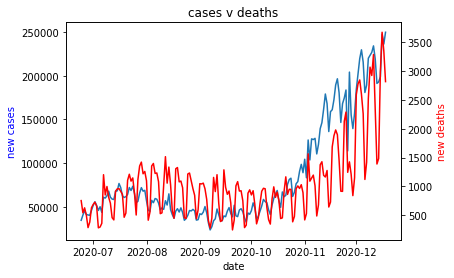

In [3]:
fig, ax = plt.subplots()
plt.title("cases v deaths") 
ax.set_xlabel("date") 
ax.set_ylabel("new cases", color="blue") 
ax.plot(dates, new_cases, label="cases")

ax2 = ax.twinx()

ax2.plot(dates, new_deaths, color="red", label="deaths")
ax2.set_ylabel("new deaths", color="red")

plt.show()

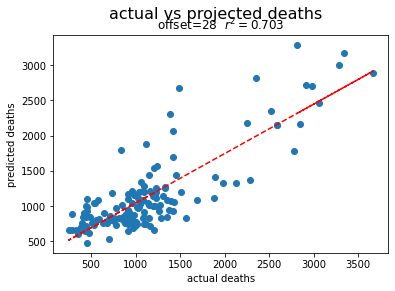

In [4]:
model, r2, predictions, deaths, offset = FindBestModelOffset(new_cases, new_deaths, 45)
fig = plt.figure()
fig.suptitle('actual vs projected deaths', fontsize=16)
ax = fig.add_subplot(111)
ax.set_title(rf"offset={offset}  $r^2={round(r2,3)}$")

plt.xlabel("actual deaths")
plt.ylabel("predicted deaths")
z = np.polyfit(deaths, predictions, 1)
p = np.poly1d(z)
plt.plot(deaths, p(deaths), "r--")
plt.scatter(deaths, predictions)

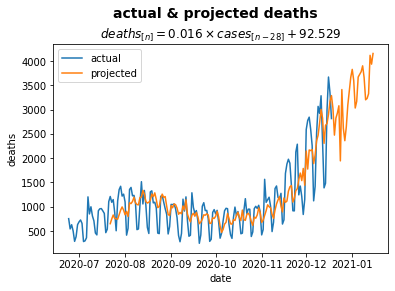

In [5]:
projected_dates, actual_deaths, projected_deaths = Predict(model, dates, new_cases, new_deaths, offset)
fig = plt.figure()
fig.suptitle('actual & projected deaths', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)

ax.set_title(fr'$deaths_{{[n]}}={round(model.coef_[0], 3)} \times cases_{{[n-{offset}]}} + ${round(model.intercept_, 3)}')
ax.set_xlabel('date')
ax.set_ylabel('deaths')

ax.plot(projected_dates, actual_deaths, label="actual")
ax.plot(projected_dates, projected_deaths, label="projected")
ax.legend()
plt.show()

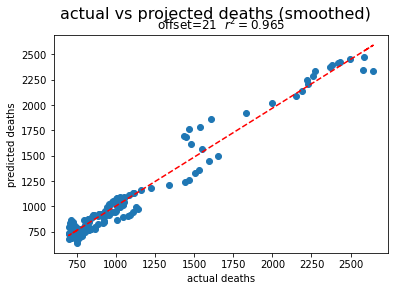

In [6]:
model, r2, predictions, deaths, offset = FindBestModelOffset(new_cases_smoothed, new_deaths_smoothed, 45)
fig = plt.figure()
fig.suptitle('actual vs projected deaths (smoothed)', fontsize=16)
ax = fig.add_subplot(111)
ax.set_title(rf"offset={offset}  $r^2={round(r2,3)}$")

plt.xlabel("actual deaths")
plt.ylabel("predicted deaths")
z = np.polyfit(deaths, predictions, 1)
p = np.poly1d(z)
plt.plot(deaths, p(deaths), "r--")
plt.scatter(deaths, predictions)

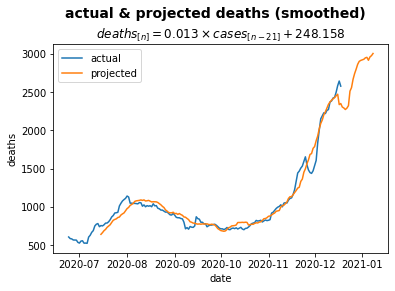

In [7]:
projected_dates, actual_deaths, projected_deaths = Predict(model, dates, new_cases_smoothed, new_deaths_smoothed, offset)
fig = plt.figure()
fig.suptitle('actual & projected deaths (smoothed)', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)

ax.set_title(fr'$deaths_{{[n]}}={round(model.coef_[0], 3)} \times cases_{{[n-{offset}]}} + ${round(model.intercept_, 3)}')
ax.set_xlabel('date')
ax.set_ylabel('deaths')

ax.plot(projected_dates, actual_deaths, label="actual")
ax.plot(projected_dates, projected_deaths, label="projected")
ax.legend()
plt.show()